In [ ]:
#default_exp cam

<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/nbs/82_timeseries_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

# Model Interpretation using CAM and GRAD-CAM
> This feature allows producing ‘visual explanations’ on how a Convolutional Neural Network (CNN) model based its classification and therefore help interpreting the obtained results. The InceptionTime model is used as an illustration.

`timeseries` offers both CAM and GRAD-CAM as well as user-defined CAM. Both CAM and GRAD-CAM are widely used in Computer Vision.

At the heart of this feature, there is a `show_cam()` method. The latter accepts the following data:

	- A Single dataset item
	- A list of dataset items that we select
	- A batch returned by `one_batch()` method

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
# !pip install git+https://github.com/fastai/fastai2.git

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
# !pip install git+https://github.com/fastai/fastcore.git

In [ ]:
# Run this cell to install the latest version of timeseries shared on github
# !pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from fastai2.imports import *
from fastai2.basics import *
from fastai2.callback.hook import *
from fastai2.vision.data import get_grid

In [ ]:
# export
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

## GunPoint Dataset
> The dataset was obtained by capturing two actors transiting between
yoga poses in front of a green screen. The problem is to
discriminate between one actor (male) and another (female). Each
image was converted to a one dimensional series by finding the
outline and measuring the distance of the outline to the centre.

![](images/gunpoint.png)

In [ ]:
# export
class CMAP():
    'There are 164 different palettes.'
    Accent = 'Accent'
    Accent_r = 'Accent_r'
    Blues = 'Blues'
    Blues_r = 'Blues_r'
    BrBG = 'BrBG'
    BrBG_r = 'BrBG_r'
    BuGn = 'BuGn'
    BuGn_r = 'BuGn_r'
    BuPu = 'BuPu'
    BuPu_r = 'BuPu_r'
    CMRmap = 'CMRmap'
    CMRmap_r = 'CMRmap_r'
    Dark2 = 'Dark2'
    Dark2_r = 'Dark2_r'
    GnBu = 'GnBu'
    GnBu_r = 'GnBu_r'
    Greens = 'Greens'
    Greens_r = 'Greens_r'
    Greys = 'Greys'
    Greys_r = 'Greys_r'
    OrRd = 'OrRd'
    OrRd_r = 'OrRd_r'
    Oranges = 'Oranges'
    Oranges_r = 'Oranges_r'
    PRGn = 'PRGn'
    PRGn_r = 'PRGn_r'
    Paired = 'Paired'
    Paired_r = 'Paired_r'
    Pastel1 = 'Pastel1'
    Pastel1_r = 'Pastel1_r'
    Pastel2 = 'Pastel2'
    Pastel2_r = 'Pastel2_r'
    PiYG = 'PiYG'
    PiYG_r = 'PiYG_r'
    PuBu = 'PuBu'
    PuBuGn = 'PuBuGn'
    PuBuGn_r = 'PuBuGn_r'
    PuBu_r = 'PuBu_r'
    PuOr = 'PuOr'
    PuOr_r = 'PuOr_r'
    PuRd = 'PuRd'
    PuRd_r = 'PuRd_r'
    Purples = 'Purples'
    Purples_r = 'Purples_r'
    RdBu = 'RdBu'
    RdBu_r = 'RdBu_r'
    RdGy = 'RdGy'
    RdGy_r = 'RdGy_r'
    RdPu = 'RdPu'
    RdPu_r = 'RdPu_r'
    RdYlBu = 'RdYlBu'
    RdYlBu_r = 'RdYlBu_r'
    RdYlGn = 'RdYlGn'
    RdYlGn_r = 'RdYlGn_r'
    Reds = 'Reds'
    Reds_r = 'Reds_r'
    Set1 = 'Set1'
    Set1_r = 'Set1_r'
    Set2 = 'Set2'
    Set2_r = 'Set2_r'
    Set3 = 'Set3'
    Set3_r = 'Set3_r'
    Spectral = 'Spectral'
    Spectral_r = 'Spectral_r'
    Wistia = 'Wistia'
    Wistia_r = 'Wistia_r'
    YlGn = 'YlGn'
    YlGnBu = 'YlGnBu'
    YlGnBu_r = 'YlGnBu_r'
    YlGn_r = 'YlGn_r'
    YlOrBr = 'YlOrBr'
    YlOrBr_r = 'YlOrBr_r'
    YlOrRd = 'YlOrRd'
    YlOrRd_r = 'YlOrRd_r'
    afmhot = 'afmhot'
    afmhot_r = 'afmhot_r'
    autumn = 'autumn'
    autumn_r = 'autumn_r'
    binary = 'binary'
    binary_r = 'binary_r'
    bone = 'bone'
    bone_r = 'bone_r'
    brg = 'brg'
    brg_r = 'brg_r'
    bwr = 'bwr'
    bwr_r = 'bwr_r'
    cividis = 'cividis'
    cividis_r = 'cividis_r'
    cool = 'cool'
    cool_r = 'cool_r'
    coolwarm = 'coolwarm'
    coolwarm_r = 'coolwarm_r'
    copper = 'copper'
    copper_r = 'copper_r'
    cubehelix = 'cubehelix'
    cubehelix_r = 'cubehelix_r'
    flag = 'flag'
    flag_r = 'flag_r'
    gist_earth = 'gist_earth'
    gist_earth_r = 'gist_earth_r'
    gist_gray = 'gist_gray'
    gist_gray_r = 'gist_gray_r'
    gist_heat = 'gist_heat'
    gist_heat_r = 'gist_heat_r'
    gist_ncar = 'gist_ncar'
    gist_ncar_r = 'gist_ncar_r'
    gist_rainbow = 'gist_rainbow'
    gist_rainbow_r = 'gist_rainbow_r'
    gist_stern = 'gist_stern'
    gist_stern_r = 'gist_stern_r'
    gist_yarg = 'gist_yarg'
    gist_yarg_r = 'gist_yarg_r'
    gnuplot = 'gnuplot'
    gnuplot2 = 'gnuplot2'
    gnuplot2_r = 'gnuplot2_r'
    gnuplot_r = 'gnuplot_r'
    gray = 'gray'
    gray_r = 'gray_r'
    hot = 'hot'
    hot_r = 'hot_r'
    hsv = 'hsv'
    hsv_r = 'hsv_r'
    inferno = 'inferno'
    inferno_r = 'inferno_r'
    jet = 'jet'
    jet_r = 'jet_r'
    magma = 'magma'
    magma_r = 'magma_r'
    nipy_spectral = 'nipy_spectral'
    nipy_spectral_r = 'nipy_spectral_r'
    ocean = 'ocean'
    ocean_r = 'ocean_r'
    pink = 'pink'
    pink_r = 'pink_r'
    plasma = 'plasma'
    plasma_r = 'plasma_r'
    prism = 'prism'
    prism_r = 'prism_r'
    rainbow = 'rainbow'
    rainbow_r = 'rainbow_r'
    seismic = 'seismic'
    seismic_r = 'seismic_r'
    spring = 'spring'
    spring_r = 'spring_r'
    summer = 'summer'
    summer_r = 'summer_r'
    tab10 = 'tab10'
    tab10_r = 'tab10_r'
    tab20 = 'tab20'
    tab20_r = 'tab20_r'
    tab20b = 'tab20b'
    tab20b_r = 'tab20b_r'
    tab20c = 'tab20c'
    tab20c_r = 'tab20c_r'
    terrain = 'terrain'
    terrain_r = 'terrain_r'
    twilight = 'twilight'
    twilight_r = 'twilight_r'
    twilight_shifted = 'twilight_shifted'
    twilight_shifted_r = 'twilight_shifted_r'
    viridis = 'viridis'
    viridis_r = 'viridis_r'
    winter = 'winter'
    winter_r = 'winter_r'

In [ ]:
# You can choose any of univariate dataset listed the `data.py` file
dsname =  'GunPoint'

In [ ]:
# url = 'http://www.timeseriesclassification.com/Downloads/GunPoint.zip'
path = unzip_data(URLs_TS.UNI_GUN_POINT)
path

Path('/home/farid/.fastai/data/GunPoint')

In [ ]:
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('/home/farid/.fastai/data/GunPoint/GunPoint_TRAIN.arff'),
 Path('/home/farid/.fastai/data/GunPoint/GunPoint_TEST.arff')]

In [ ]:
data = TSData.from_arff(fnames)
print(data)

TSData:
 Datasets names (concatenated): ['GunPoint_TRAIN', 'GunPoint_TEST']
 Filenames:                     [Path('/home/farid/.fastai/data/GunPoint/GunPoint_TRAIN.arff'), Path('/home/farid/.fastai/data/GunPoint/GunPoint_TEST.arff')]
 Data shape: (200, 1, 150)
 Targets shape: (200,)
 Nb Samples: 200
 Nb Channels:           1
 Sequence Length: 150


In [ ]:
items = data.get_items()

In [ ]:
# dls = TSDataLoaders.from_files(fnames=fnames, batch_tfms=batch_tfms, num_workers=0, device=default_device())
dls = TSDataLoaders.from_files(bs=64, fnames=fnames, num_workers=0, device=default_device())

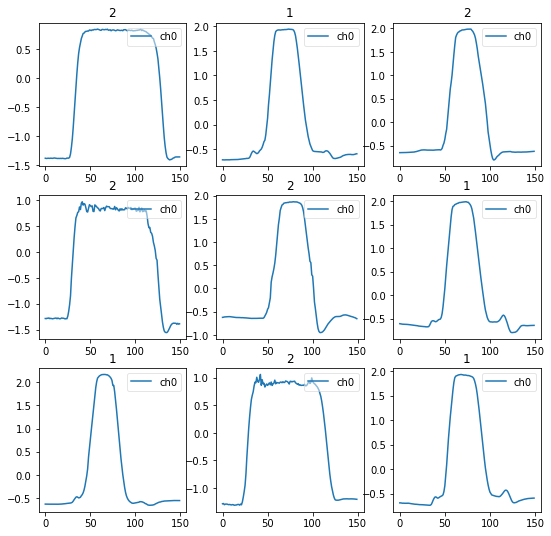

In [ ]:
dls.show_batch(max_n=9)

## Training Model

In [ ]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= dls.c 
c_in,c_out

(1, 2)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
# model

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)
# print(learn.summary())

(0.017378008365631102, 0.00013182566908653826)

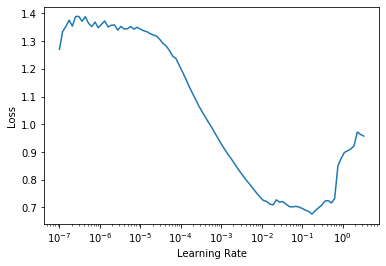

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:
epochs=24; lr_max=1e-3
learn.fit_one_cycle(epochs, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,1.313919,0.692904,0.575000,00:00
1,1.248768,0.693099,0.575000,00:00
2,1.141171,0.694189,0.425000,00:00
3,1.070883,0.695346,0.425000,00:00
4,0.944331,0.696796,0.425000,00:00
5,0.842656,0.700287,0.425000,00:00
6,0.757936,0.703399,0.425000,00:00
7,0.685084,0.706720,0.425000,00:00
8,0.626400,0.711806,0.425000,00:00
9,0.579209,0.714237,0.425000,00:00


## Graphs

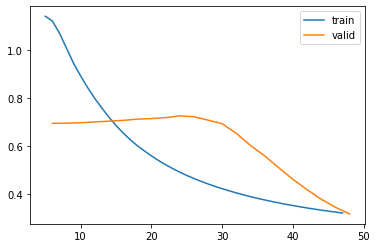

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# learn.show_results(max_n=9)

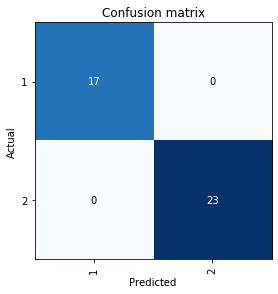

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[]

## Heatmap

In [ ]:
model = learn.model.eval()

In [ ]:
model[5]

SequentialEx(
  (layers): ModuleList(
    (0): InceptionModule(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
      (convs): ModuleList(
        (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
        (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
        (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      )
      (maxpool_bottleneck): Sequential(
        (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
      (bn_relu): Sequential(
        (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
    )
    (1): Shortcut(
      (act_fn): ReLU(inplace=True)
      (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
model[6]

AdaptiveConcatPool1d(
  (ap): AdaptiveAvgPool1d(output_size=1)
  (mp): AdaptiveMaxPool1d(output_size=1)
)

## `hooked_backward()` function

In [ ]:
#export
def hooked_backward(x, y, model, layer):
    "A function hook to get access to both activation and gradient values of a given `model` at the layer number `layer`"
    xb= x[None, :] # xb = x.unsqueeze()
    with hook_output(model[layer]) as hook_a: 
        with hook_output(model[layer], grad=True) as hook_g:
            preds = model(xb)
            preds[0,int(y)].backward()
    return hook_a,hook_g

In [ ]:
show_doc(hooked_backward)

<h4 id="hooked_backward" class="doc_header"><code>hooked_backward</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hooked_backward</code>(**`x`**, **`y`**, **`model`**, **`layer`**)

A function hook to get access to both activation and gradient values of a given `model` at the layer number `layer`

## Note
> Through the notebook, I will be using GunPoint dataset and use its dimensions to illustrate tensors shapes in order to make the code more readable

## `hook_acts()` function

In [ ]:
#export
def hook_acts(x, y, model, layer):
    "A hook function to get access to activation values of a given `model` at the layer number `layer`"
    hook_a,hook_g = hooked_backward(x, y, model, layer)
    acts  = hook_a.stored[0].cpu()
    return acts

In [ ]:
show_doc(hook_acts)

<h4 id="hook_acts" class="doc_header"><code>hook_acts</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hook_acts</code>(**`x`**, **`y`**, **`model`**, **`layer`**)

A hook function to get access to activation values of a given `model` at the layer number `layer`

In [ ]:
# export
def cam_acts(tseries, y, model, layer, reduction='mean', force_scale=True, scale_range=(0, 1)): # x.shape = [1, 150]
    "Compute raw CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds to       (mean + max)/2"
    
    # acts.shape = [128, 150]
    acts = hook_acts(tseries, y, model, layer) 
    acts = acts.cpu()
    
    if reduction=='mean': acts = acts.mean(0)                                  # mean.shape = [150]
    if reduction=='median': acts = acts.median(0).values                       # mendia.shape = [150]
    if reduction=='max' : acts = acts.max(0).values                             # max.shape = [150]
    if reduction=='mean_max': acts = (acts.mean(0) + acts.max(0).values)/2 # max_mean.shape = [150]
    # print(f'Reduction: {reduction}')

    if force_scale==True:
        acts = (acts - acts.min())/(acts.max() - acts.min())*(scale_range[1] - scale_range[0]) + scale_range[0]
        return acts[None, :] # acts.shape = [1, 150]
    else:
        return acts[None, :] # acts.shape = [1, 150]

# store function name
cam_acts.name = r'CAM'

In [ ]:
show_doc(cam_acts)

<h4 id="cam_acts" class="doc_header"><code>cam_acts</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>cam_acts</code>(**`tseries`**, **`y`**, **`model`**, **`layer`**, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*)

Compute raw CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds to       (mean + max)/2

In [ ]:
#export
def acts_scaled(acts, scale_range=(0, 1)):
    "Scale values between [scale_range[0]...scale_range[1]]. By default, it scales `acts` between 0 and 1"
    return (acts - acts.min())/(acts.max() - acts.min())*(scale_range[1] - scale_range[0]) + scale_range[0]    
    

In [ ]:
show_doc(acts_scaled)

<h4 id="acts_scaled" class="doc_header"><code>acts_scaled</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>acts_scaled</code>(**`acts`**, **`scale_range`**=*`(0, 1)`*)

Scale values between [scale_range[0]...scale_range[1]]. By default, it scales `acts` between 0 and 1

In [ ]:
#export
def grad_cam_acts(tseries, y, model, layer, reduction='mean', force_scale=True, scale_range=(0, 1)): # x.shape = [1, 150]
    "Compute raw CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds       to (mean + max)/2" 
    hook_a,hook_g = hooked_backward(tseries, y, model, layer)
    
    acts  = hook_a.stored[0].cpu()      # acts.shape = [128, 150]
    grad = hook_g.stored[0][0].cpu()    # grad.shape = [128, 150]

    # grad_chan.shape = [128]
    if reduction=='mean': grad_chan = grad.mean(1)
    if reduction=='median': grad_chan = grad.median(1).values
    if reduction=='max': grad_chan = grad.max(1).values
    if reduction=='mean_max': grad_chan = (grad.mean(1) + grad.max(1).values)/2
    # print(f'Reduction: {reduction}')
    
    mult = (acts*grad_chan[..., None])  # shape grad_chan[..., None] => [128, 1] => broadcast to => [128, 150]
    acts = mult.mean(0)                 # mean.shape = [150]
        
    if force_scale==True:
        acts = (acts - acts.min())/(acts.max() - acts.min())*(scale_range[1] - scale_range[0]) + scale_range[0]
        return acts[None, :]    # acts.shape = [1, 150]
    else:
        return acts[None, :]    # acts.shape = [1, 150]       

# store function name
grad_cam_acts.name = r'GRAD-CAM'

In [ ]:
show_doc(grad_cam_acts)

<h4 id="grad_cam_acts" class="doc_header"><code>grad_cam_acts</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>grad_cam_acts</code>(**`tseries`**, **`y`**, **`model`**, **`layer`**, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*)

Compute raw CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds       to (mean + max)/2

## User defined CAM method
> The users can defined their own CAM method and plug it in the `show_cam()` method. Check out both `cam_acts` and `grad_cam_acts` to see how easy you can create your own CAM function

In [ ]:
# export
# # User defined CAM method
# def user_defined_cam_acts(tseries, y, model, layer, reduction='mean', force_scale=True, scale_range=(0, 1)):
# "Compute User-defined CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds to       (mean + max)/2"
    
#     # acts.shape = [128, 150]
#     acts = your_cam_method(tseries, y, model, layer) 

#     if reduction=='mean': acts = acts.mean(0)                                  # mean.shape = [150]
#     if reduction=='median': acts = acts.median(0).values                       # mendia.shape = [150]
#     if reduction=='max' : acts = acts.max(0).values                             # max.shape = [150]
#     if reduction=='mean_max': acts = (acts.mean(0) + acts.max(0).values)/2 # max_mean.shape = [150]
#     # print(f'Reduction: {reduction}')

#     if force_scale==True:
#         acts = (acts - acts.min())/(acts.max() - acts.min())*(scale_range[1] - scale_range[0]) + scale_range[0]
#         return acts[None, :] # acts.shape = [1, 150]
#     else:
#         return acts[None, :] # acts.shape = [1, 150]

# # store function name
# cam_acts.name = r'user_defined_cam_acts'

# show_cam(batch, model, layer=5, i2o=i2o, func_cam=user_defined_cam_acts)

In [ ]:
#export
@delegates(LineCollection.__init__)
def CAM_batch_compute(b, model, layer=5, func_cam=grad_cam_acts, reduction='mean', force_scale=True, scale_range=(0, 1),**kwargs):
      
    'Compute either CAM for a list (b) of time series `tseries` .'
  
    ts_min_max = [1e10, -1e10]
    acts_min_max = [1e10, -1e10]
    tseries_list = []
    y_list = []
    acts_list = []
    idx = 1   
    # Compute activation for each time series `tseries` here below
    # Process one time series at the time
    for item in b:
        # print(f'idx = {idx}')
        tseries, y = item
        y_list.append(y)        
        acts = func_cam(tseries, y, model, layer=layer, reduction=reduction, force_scale=force_scale, scale_range=scale_range)

        # remove the first dimension : [1, 150] -> [150]
        acts = acts.squeeze().numpy()
        tseries = tseries.cpu().squeeze().numpy()

        tseries_list.append(tseries)
        acts_list.append(acts)
        
        # set `tseries min and max
        min, max = tseries.min(), tseries.max()
        # print('min - max', min, max)
        if min<ts_min_max[0]: ts_min_max[0] = min
        if max>ts_min_max[1]: ts_min_max[1] = max
        # print('tsmin - tsmax', ts_min_max[0], ts_min_max[1])
        
        # set `tseries min and max
        min, max = acts.min(), acts.max()
        # print('min - max', min, max)
        if min<acts_min_max[0]: acts_min_max[0] = min
        if max>acts_min_max[1]: acts_min_max[1] = max
        # print('actsmin - actsmax', acts_min_max[0], acts_min_max[1])
        
        idx += 1

    return (tseries_list, acts_list, y_list, ts_min_max, acts_min_max)


In [ ]:
def _listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    # if is_iter(o): return list(o)
    return [o]

In [ ]:
#export
def batchify(dataset, idxs): 
    'Return a list of items for the supplied dataset and idxs'
    tss = [dataset[i][0] for i in idxs]
    ys  = [dataset[i][1] for i in idxs]
    return (tss, ys)

In [ ]:
#export
def itemize(batch):
    #take a batch and create a list of items. Each item represent a tuple of (tseries, y)
    tss, ys = batch
    b = [(ts, y) for ts,y in zip(tss, ys)]
    return b

In [ ]:
dls.test = dls.train.new(bs=3)
batch = dls.test.one_batch()
# type(batch), len(batch), type(batch[0]), batch

In [ ]:
# b = itemize(batch)
# print(b)

In [ ]:
# tss, ys = batch
# tss, ys

In [ ]:
b = itemize(batch)
# b[0]

In [ ]:
# export
def get_list_items(dataset, idxs): 
    'Return a list of items for the supplied dataset and idxs'
    list = [dataset[i] for i in idxs]
    return list

In [ ]:
default_device()

device(type='cuda', index=0)

In [ ]:
# export
def get_batch(dataset, idxs): 
    'Return a batch based on list of items from dataset at idxs'
    list_items = [dataset[i] for i in idxs]
    tdl = TfmdDL(list_items, bs=2, num_workers=0)
    tdl.to(default_device())
    return tdl.one_batch()

In [ ]:
show_doc(get_batch)

<h4 id="get_batch" class="doc_header"><code>get_batch</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>get_batch</code>(**`dataset`**, **`idxs`**)

Return a batch based on list of items from dataset at idxs

In [ ]:
idxs = [0,3]
x, y = get_batch(dls.train.dataset, idxs)
x[0].device, x[0]

(device(type='cuda', index=0),
 tensor([[-0.6029, -0.6026, -0.6015, -0.6017, -0.6001, -0.5971, -0.5969, -0.5967,
          -0.5989, -0.5982, -0.5980, -0.5975, -0.5954, -0.5973, -0.5926, -0.5877,
          -0.5867, -0.5845, -0.5827, -0.5834, -0.5836, -0.5843, -0.5837, -0.5826,
          -0.5847, -0.5844, -0.5832, -0.5829, -0.5835, -0.5841, -0.5802, -0.5598,
          -0.5372, -0.5194, -0.5131, -0.5119, -0.5240, -0.5474, -0.5717, -0.5778,
          -0.5745, -0.5560, -0.5241, -0.5013, -0.4591, -0.4084, -0.3357, -0.2329,
          -0.1382,  0.0548,  0.2929,  0.4062,  0.6587,  0.8967,  1.1368,  1.3721,
           1.5708,  1.7629,  1.8698,  1.9778,  1.9928,  2.0151,  2.0318,  2.0364,
           2.0408,  2.0400,  2.0472,  2.0440,  2.0450,  2.0503,  2.0475,  2.0473,
           2.0498,  2.0530,  2.0429,  2.0214,  2.0214,  1.9742,  1.9128,  1.8068,
           1.6602,  1.5266,  1.3651,  1.2026,  1.0339,  0.8960,  0.7388,  0.6017,
           0.4597,  0.3081,  0.1812,  0.0638, -0.0471, -0.1335, -0.

In [ ]:
list_items = get_list_items(dls.train.dataset, idxs)
# list_items

In [ ]:
tdl = TfmdDL(list_items, bs=2, num_workers=0)
tdl.to(default_device())
batch = tdl.one_batch()
# batch[0][0].device, batch[0], batch[1]

In [ ]:
#export
@delegates(LineCollection.__init__)
def show_cam(batch, model, layer=5, func_cam=cam_acts, reduction='mean', force_scale=True, 
                    scale_range=(0, 1), cmap="Spectral_r", linewidth=4, linestyles='solid', alpha=1.0, scatter=False,
                    i2o=noop, figsize=None, multi_fig=False, **kwargs):
    'Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the         scaled CAM values. The time series are plot either on a single figure or on a multiple figures'

    # args = []
    if multi_fig==False:
        if figsize==None: figsize=(6,4)
        cam_batch_plot_one_fig(batch, model, layer=layer, func_cam=func_cam, reduction=reduction, force_scale=force_scale, 
                            scale_range=scale_range, cmap=cmap, linewidth=linewidth, linestyles=linestyles, alpha=alpha,
                            scatter=scatter, i2o=i2o, figsize=figsize, **kwargs) 
    else:
        if figsize==None: figsize=(13,4)
        cam_batch_plot_multi_fig(batch, model, layer=layer, func_cam=func_cam, reduction=reduction, force_scale=force_scale, 
                            scale_range=scale_range, cmap=cmap, linewidth=linewidth, linestyles=linestyles, alpha=alpha,
                            scatter=scatter, i2o=i2o, figsize=figsize, **kwargs) 
                            


In [ ]:
show_doc(show_cam)

<h4 id="show_cam" class="doc_header"><code>show_cam</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>show_cam</code>(**`batch`**, **`model`**, **`layer`**=*`5`*, **`func_cam`**=*`'cam_acts'`*, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*, **`cmap`**=*`'Spectral_r'`*, **`linewidth`**=*`4`*, **`linestyles`**=*`'solid'`*, **`alpha`**=*`1.0`*, **`scatter`**=*`False`*, **`i2o`**=*`'noop'`*, **`figsize`**=*`None`*, **`multi_fig`**=*`False`*, **`linewidths`**=*`None`*, **`colors`**=*`None`*, **`antialiaseds`**=*`None`*, **`offsets`**=*`None`*, **`transOffset`**=*`None`*, **`norm`**=*`None`*, **`pickradius`**=*`5`*, **`zorder`**=*`2`*, **`facecolors`**=*`'none'`*)

Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the         scaled CAM values. The time series are plot either on a single figure or on a multiple figures

In [ ]:
#export
@delegates(LineCollection.__init__)
def cam_batch_plot_one_fig(batch, model, layer=5, func_cam=cam_acts, reduction='mean', force_scale=True, 
                            scale_range=(0, 1), cmap="Spectral_r", linewidth=4, linestyles='solid', alpha=1.0, scatter=False,
                            i2o=noop, figsize=(6,4), **kwargs):
    
    'Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the   scaled CAM values. The time series are plot on a single figure'

    """
    linestyles : string, tuple, optional
            Either one of [ 'solid' | 'dashed' | 'dashdot' | 'dotted' ], or
            a dash tuple. The dash tuple is:(offset, onoffseq)
            where ``onoffseq`` is an even length tuple of on and off ink in points.
    """
    
    plt.figure(figsize=figsize)
    
    # batch use-cases
    # batch can be either: 
    #   - a real batch meaning a tuple of (a list of tseries, a list of y)
    #   - a list of tuples (tseries, y) that we build from a dataset (a dataset item is a tuple of (tseries, y) 
    #   - a single dataset item meaning a a tuple of (tseries, y)
    
    if not isinstance(batch, list):
        if len(batch[0].shape)==3:   # a real batch meaning a tuple of (a list of tseries, a list of y)
            b = itemize(batch)
        elif len(batch[0].shape)==2: # a single dataset item meaning a a tuple of (tseries, y)m
            b = [batch]
    else: b = batch # a list of tuples (tseries, y) that we build from a dataset (a dataset item is a tuple of (tseries, y)
            
    # b = _listify(b)    
    tseries_list, acts_list, y_list, ts_min_max, acts_min_max = CAM_batch_compute(b, model, layer=layer, func_cam=func_cam,                                              reduction=reduction, force_scale=force_scale, scale_range=scale_range, **kwargs)  
 
    levels = 254
    cmap = plt.get_cmap(cmap, lut=levels) #seismic
    if force_scale==True:
        colors = cmap(np.linspace(scale_range[0], scale_range[1], levels))
        norm = BoundaryNorm(np.linspace(scale_range[0], scale_range[1], levels+1), len(colors))
    else:
        colors = cmap(np.linspace(acts_min_max[0], acts_min_max[1], levels))
        norm = BoundaryNorm(np.linspace(acts_min_max[0], acts_min_max[1], levels+1), len(colors))

    # Plot activation `acts` (superimposed on the original time series `tseries)
    idx = 1
    for tseries, acts, y in zip(tseries_list, acts_list, y_list):
        t = np.arange(tseries.shape[-1])
        if scatter==True:
            # plt.figure(figsize=(13,4))
            # plt.subplot(1, 2, idx) 
            plt.scatter(t, tseries, cmap=cmap, c = acts, linewidths=linewidth )
            idx += 1
        else:
            points = np.array([t, tseries]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            if idx==2: linestyles='dashed'
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=linewidth, linestyles=linestyles, alpha=alpha,                                    **kwargs )
            lc.set_array(acts)
            lc.set_linewidth(linewidth)
            plt.gca().add_collection(lc)
            idx += 1 

    plt.xlim(t.min(), t.max())
    plt.ylim(ts_min_max[0]*1.2, ts_min_max[1]*1.2)

    titles = [i2o(y) for y in y_list]
    title = ' - '.join(titles)
    if not hasattr(func_cam, 'name'): func_cam.name = str(func_cam)
    title =  f'[{title}] - {func_cam.name} - {reduction}'
    # print(f'Title: {title}')
    plt.title(title)   
    
    scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
    scalarmappaple.set_array(acts)
    plt.colorbar(scalarmappaple)
    plt.show()

In [ ]:
show_doc(cam_batch_plot_one_fig)

<h4 id="cam_batch_plot_one_fig" class="doc_header"><code>cam_batch_plot_one_fig</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>cam_batch_plot_one_fig</code>(**`batch`**, **`model`**, **`layer`**=*`5`*, **`func_cam`**=*`'cam_acts'`*, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*, **`cmap`**=*`'Spectral_r'`*, **`linewidth`**=*`4`*, **`linestyles`**=*`'solid'`*, **`alpha`**=*`1.0`*, **`scatter`**=*`False`*, **`i2o`**=*`'noop'`*, **`figsize`**=*`(6, 4)`*, **`linewidths`**=*`None`*, **`colors`**=*`None`*, **`antialiaseds`**=*`None`*, **`offsets`**=*`None`*, **`transOffset`**=*`None`*, **`norm`**=*`None`*, **`pickradius`**=*`5`*, **`zorder`**=*`2`*, **`facecolors`**=*`'none'`*)

Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the   scaled CAM values. The time series are plot on a single figure

In [ ]:
#export
@delegates(LineCollection.__init__)
def cam_batch_plot_multi_fig(batch, model, layer=5, func_cam=cam_acts, reduction='mean',force_scale=True, scale_range=(0, 1),                        cmap="Spectral_r", linewidth=4, linestyles='solid', alpha=1.0, scatter=False, i2o=noop, figsize=(13,4),                        **kwargs):    
    'Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the        scaled CAM values. Each time series is plotted on a separate figure'

    # batch use-cases
    # batch can be either: 
    #   - a real batch meaning a tuple of (a list of tseries, a list of y)
    #   - a list of tuples (tseries, y) that we build from a dataset (a dataset item is a tuple of (tseries, y) 
    #   - a single dataset item meaning a a tuple of (tseries, y)
    
    
    if not isinstance(batch, list):
        if len(batch[0].shape)==3:   # a real batch meaning a tuple of (a list of tseries, a list of y)
            b = itemize(batch)
        elif len(batch[0].shape)==2: # a single dataset item meaning a a tuple of (tseries, y)m
            b = [batch]
    else: 
        b = batch # a list of tuples (tseries, y) that we build from a dataset (a dataset item is a tuple of (tseries, y)ch
    n_samples = len(b)

    # b = _listify(b)
    tseries_list, acts_list, y_list, ts_min_max, acts_min_max = CAM_batch_compute(b, model, layer=layer, func_cam=func_cam,                                              reduction=reduction, force_scale=force_scale, scale_range=scale_range, **kwargs)  
    levels = 254
    cmap = plt.get_cmap(cmap, lut=levels) #seismic
    if force_scale==True:
        colors = cmap(np.linspace(scale_range[0], scale_range[1], levels))
        norm = BoundaryNorm(np.linspace(scale_range[0], scale_range[1], levels+1), len(colors))
    else:
        colors = cmap(np.linspace(acts_min_max[0], acts_min_max[1], levels))
        norm = BoundaryNorm(np.linspace(acts_min_max[0], acts_min_max[1], levels+1), len(colors))

    
    # fig, axs = get_grid(4, return_fig=True, figsize=(10, 8))
    # Plot activation `acts` (superimposed on the original time series `tseries)   
    lc_list=[]
    title_list=[]
    idx = 1
    for tseries, acts, y in zip(tseries_list, acts_list, y_list):
        t = np.arange(tseries.shape[-1])
        if scatter==True:
            plt.figure(figsize=figsize)
            plt.subplot(1, n_samples, idx) 
            plt.scatter(t, tseries, cmap=cmap, c = acts)
            title = i2o(y)
            if not hasattr(func_cam, 'name'): func_cam.name = str(func_cam)
            title =  f'[{title}] - {func_cam.name} - {reduction}'
            plt.xlim(t.min(), t.max())
            plt.ylim(ts_min_max[0]*1.2, ts_min_max[1]*1.2)
            plt.title(title)
            scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
            scalarmappaple.set_array(acts)
            plt.colorbar(scalarmappaple)
            plt.show()
            idx += 1
        else:
            points = np.array([t, tseries]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=linewidth, linestyles=linestyles, alpha=alpha,                                    **kwargs )
            lc.set_array(acts)
            lc.set_linewidth(linewidth)
            lc_list.append(lc)
            
            title = i2o(y)
            if not hasattr(func_cam, 'name'): func_cam.name = str(func_cam)
            title =  f'[{title}] - {func_cam.name} - {reduction}'
            title_list.append(title)
            idx += 1 
    
    # Grid
    nrows = int(math.sqrt(n_samples))
    ncols = int(np.ceil(n_samples/nrows))
    fig,axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i<n_samples else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n_samples]   
    fig.tight_layout(pad=3.0)
    
    idx = 0
    if scatter==False:
        for tseries, acts, lc, title in zip(tseries_list, acts_list, lc_list, title_list):
            im = axs[idx].add_collection(lc)
            axs[idx].set_xlim([t.min(), t.max()])
            axs[idx].set_ylim([ts_min_max[0]*1.2, ts_min_max[1]*1.2])
            axs[idx].set_title(title)
            scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
            scalarmappaple.set_array(acts)
            fig.colorbar(im, ax=axs[idx])
            idx += 1
        plt.show() 

In [ ]:
show_doc(cam_batch_plot_multi_fig)

<h4 id="cam_batch_plot_multi_fig" class="doc_header"><code>cam_batch_plot_multi_fig</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>cam_batch_plot_multi_fig</code>(**`batch`**, **`model`**, **`layer`**=*`5`*, **`func_cam`**=*`'cam_acts'`*, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*, **`cmap`**=*`'Spectral_r'`*, **`linewidth`**=*`4`*, **`linestyles`**=*`'solid'`*, **`alpha`**=*`1.0`*, **`scatter`**=*`False`*, **`i2o`**=*`'noop'`*, **`figsize`**=*`(13, 4)`*, **`linewidths`**=*`None`*, **`colors`**=*`None`*, **`antialiaseds`**=*`None`*, **`offsets`**=*`None`*, **`transOffset`**=*`None`*, **`norm`**=*`None`*, **`pickradius`**=*`5`*, **`zorder`**=*`2`*, **`facecolors`**=*`'none'`*)

Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the        scaled CAM values. Each time series is plotted on a separate figure

In [ ]:
dls.vocab

(#2) ['1','2']

In [ ]:
# export
# Example of i2o() function
# Converting CategoryTensor label into the human-readable label
lbl_dict = dict([
    (0, 'Gun'),   
    (1, 'Point')]
)
def i2o(y):
    return lbl_dict.__getitem__(y.data.item())
    # return lbl_dict.__getitem__(int(dls.tfms[1][1].decodes(y)))

In [ ]:
# x1 correspond to Gun
x1, y1 = dls.train.dataset[0]
x1.shape,y1

(torch.Size([1, 150]), TensorCategory(0, dtype=torch.int32))

In [ ]:
# x1

In [ ]:
y1.data.item()

0

In [ ]:
# x2 corresponds to Point
x2, y2 = dls.train.dataset[3]
x2.shape, x2, y2

(torch.Size([1, 150]),
 TensorTS([[-1.1308, -1.1299, -1.1220, -1.1283, -1.1267, -1.1211, -1.1285, -1.1216,
          -1.1253, -1.1280, -1.1204, -1.1312, -1.1333, -1.1271, -1.1222, -1.1204,
          -1.1301, -1.1255, -1.1269, -1.1151, -1.1252, -1.1151, -1.1152, -1.1211,
          -1.0500, -0.9909, -0.8947, -0.7542, -0.5229, -0.2759,  0.0051,  0.2586,
           0.4710,  0.6613,  0.7850,  0.9188,  0.9380,  0.9524,  0.9732,  1.0394,
           1.0695,  1.0990,  1.1004,  1.1003,  1.0073,  0.9880,  0.9977,  1.0171,
           1.0231,  1.0358,  0.9861,  0.9640,  0.9506,  0.9357,  0.9420,  0.9782,
           0.9822,  0.9710,  0.9710,  0.9118,  0.9692,  0.9453,  0.9737,  0.9999,
           0.9969,  0.9666,  0.9618,  0.9407,  0.9706,  0.9508,  0.9870,  0.9545,
           0.9538,  0.9614,  0.9487,  0.9384,  0.9384,  0.9353,  0.9263,  0.9489,
           0.9271,  0.9362,  0.9050,  0.9355,  0.9489,  0.9602,  0.9895,  1.0041,
           0.9740,  0.9751,  0.9538,  0.9564,  0.9316,  0.9329,  1.0509, 

In [ ]:
i2o(y1), i2o(y2)

('Gun', 'Point')

In [ ]:
dls.tfms[1][1].decodes(y1)

'1'

In [ ]:
# len((m.layers))

## Creating a customized batch :  list of 2 items 

> Note: This is not a batch in literal sense as used using `DataLoader.one_batch()` method. It just a list of some dataset items
- batch\[0\]: corresponds to Gun gesture
- batch\[1\]: corresponds to Point gesture

In [ ]:
idxs = [0,3]
batch = get_batch(dls.train.dataset, idxs)
batch[0][0].device, batch[1],  len(batch), type(batch)

(device(type='cuda', index=0),
 TensorCategory([0, 1], device='cuda:0', dtype=torch.int32),
 2,
 tuple)

In [ ]:
test_eq(dls.train.dataset[0][1], batch[1][0])
test_eq(dls.train.dataset[3][1], batch[1][1])
# dls.train.dataset[0][1], dls.train.dataset[3][1]

In [ ]:
test_eq(len(batch), 2)
test_eq(isinstance(batch, list), True)
test_eq(isinstance(batch, tuple), False)

## Plotting CAM for several dataset items in one shared figure 
> Example: the function expects a list of `items` and plots CAM for the provided items list.`

## 2 types of activation : `CAM` and `GRAD-CAM`

### Class Activation Map (CAM)
This option calculates the activations values at the selected layer.By default the activations curves are plotted in one single figure.

`func_cam=cam_acts` : activation function name (activation values at the chosen model layer). It is the default value
 
The figure title `[Gun - Point] - CAM - mean` should be read as follow:
- `Gun`     : class of the first curve
- `Point`   : class of the second curve
- `CAM`     : activation function name (activation values at the chosen model layer)
- `mean`    : type of reduction (read the explanation below: 4 types of reductions)

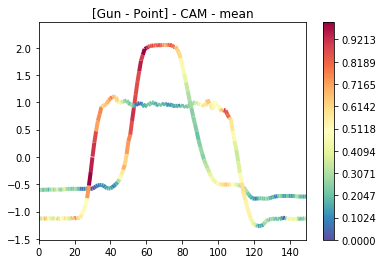

In [ ]:
# Gun - CAM - mean
show_cam(batch, model, layer=5, i2o=i2o, func_cam=cam_acts) # default:  func_cam=cam_acts, multi_fig=False, figsize=(6,4)

### Plot each time series curve in a separate figure  

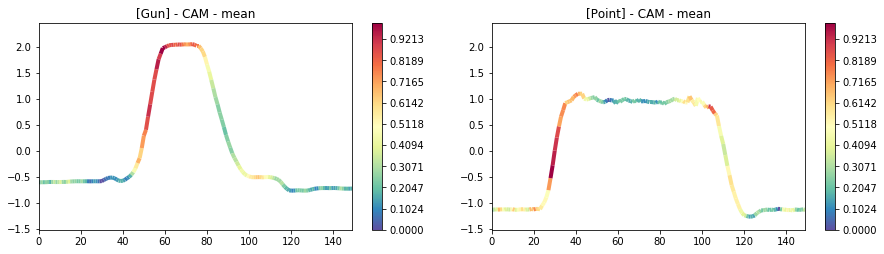

In [ ]:
# Gun - CAM - mean
show_cam(batch, model, layer=5, i2o=i2o, multi_fig=True) # default: func_cam=cam_acts, figsize=(13,4)

### Gradiant Class Activation Map (GRAD-CAM)
This option calculates the gradient activations values at the selected layer.

We supply the argument `func_cam=grad_cam_acts` to calculate the Gradient-Class Activation Map (GRAD-CAM)


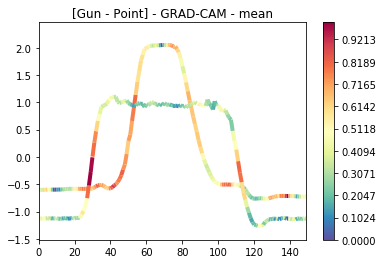

In [ ]:
#CAM - mean
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts)

### Using RAW activation values: `force_scale=False` (Non-scaled values)
By default, both `func_cam=grad_cam_acts` (GRAD-CAM) and `reduction=mean` are used
In this example, we are plotting the raw activation values (by default GRAD-CAM). Notice the values on the cmap color palette.
> We can supply a user-defined `func_cam`. See here below an example with a custom defined function `cam_acts_1`

> Pay attention to the `scale` values. Instead of being between [0..1], they are between th min and the max of the activation raw values

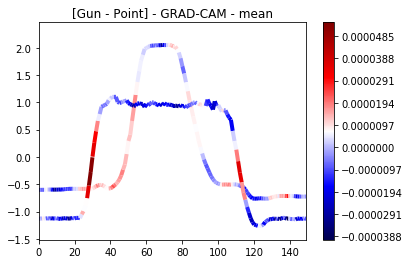

In [ ]:
#CAM - max. 
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, force_scale=False, cmap=CMAP.seismic)

### Using Scaled activation values: `force_scale=False` (default = [0..1])
In this example, we are plotting the raw activation values (by default GRAD-CAM). Notice the values on the cmap color palette bounds: [0..1]. This scale range is the default one. We can supply the argument `scale_range=(0,2)` for example to provide a user-defined range

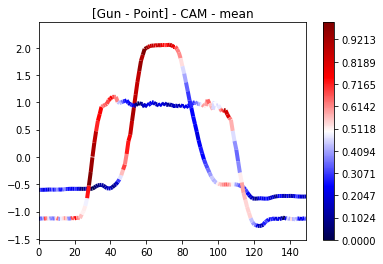

In [ ]:
# Gun - Point - CAM - mean
show_cam(batch,model, layer=5, i2o=i2o, cmap=CMAP.seismic)

## 4 types of `reduction`
When raw activities are caluculated, we obtain a tensor of [128, 150]. 128 corresponds to the number of channels. Whereas 150 represents the data points. Since the original time series is a [1, 128] tensor (univariate time series), we need to reduce the [128, 150] tensor to [1, 150]. Therefore, we have several types of reductions. 

`show_cam()` offers 4 types of reductions:
- `mean` (default)
- `median` 
- `max`
- `mean_max` (average of mean and max values)

### Using `reduction='mean'`
The default is `reduction='mean'`. We can ommit `reduction='mean'` argument

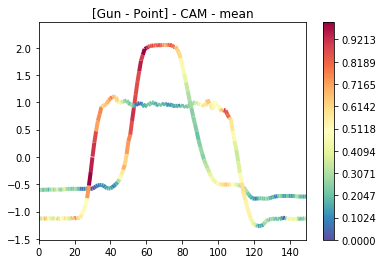

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o) 

### Using `reduction='max'`
`mean` is the default reduction. Here below, we use `max` reduction

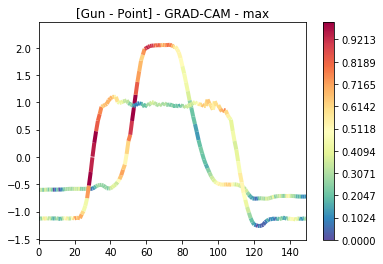

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, reduction='max')

### Using `reduction='median'`
`mean` is the default reduction. Here below, we use `median` reduction

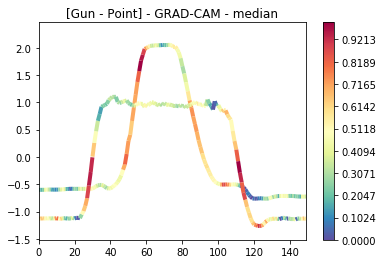

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, reduction='median')

### Using `reduction='mean_max'` 
This corresponds to : `(mean + max)/2`

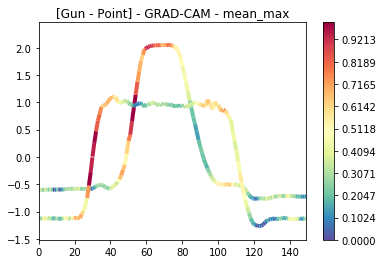

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, reduction='mean_max')

### Plotting scattered lines

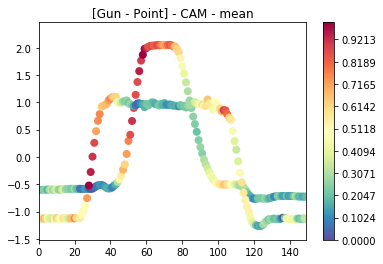

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, linewidth=2, scatter=True)

## Plotting CAM for a batch of items 
> We can also feed the show_cam() a full batch return straight from `DataLoaders` `one_batch() method as shown here below

### Creating a batch of 5 items

In [ ]:
dls.train = dls.train.new(bs=5)
batch = dls.train.one_batch()

In [ ]:
batch[0][0].device

device(type='cuda', index=0)

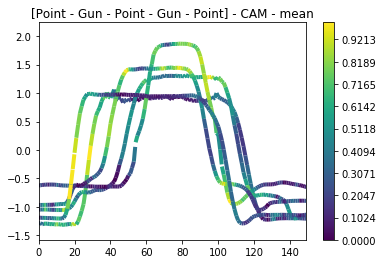

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.viridis)

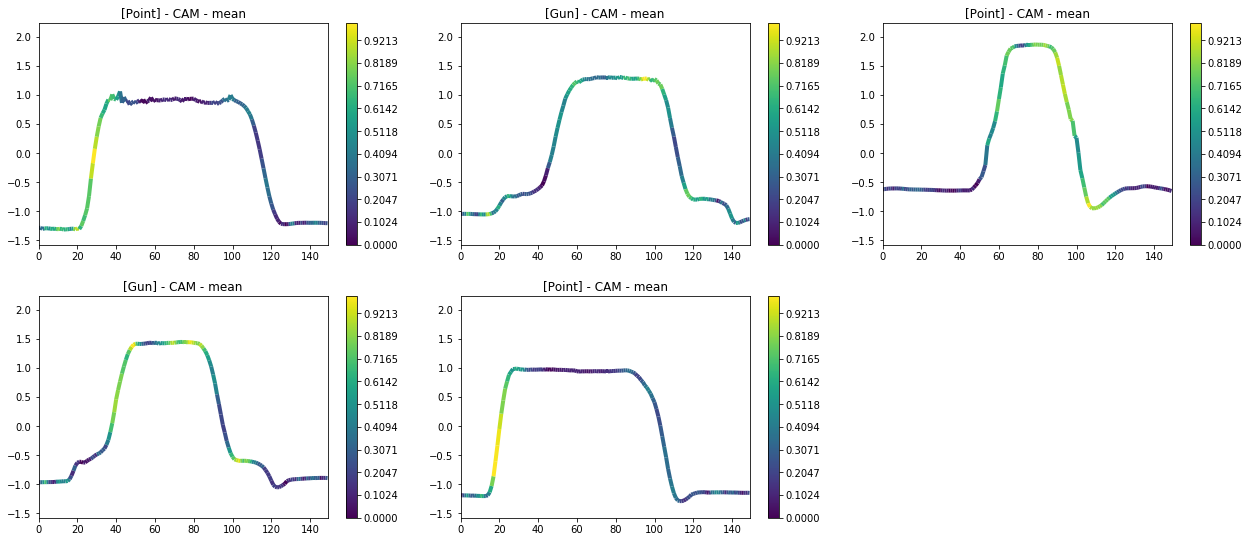

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.viridis, multi_fig=True, figsize=(18, 8))

## Plotting CAM for a single dataset item 
> We can also feed the `show_cam()` a single item

In [ ]:
# dls.train.dataset[0]
idxs = [0]
batch = get_batch(dls.train.dataset, idxs)
batch[0][0].device, batch[1],  len(batch), type(batch)

(device(type='cuda', index=0),
 TensorCategory([0], device='cuda:0', dtype=torch.int32),
 2,
 tuple)

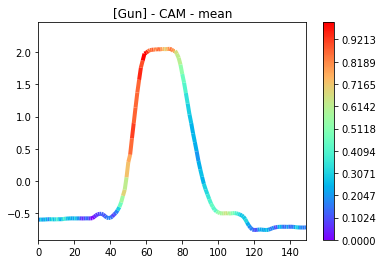

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.rainbow)

## Palettes for `cmap`
> There are `164` different palettes.  Check out `CMAP` class and its autocompletion

In [ ]:
idxs = [0, 3]
batch = get_batch(dls.train.dataset, idxs)

### RdBu_r

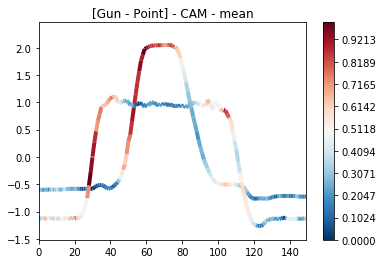

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.RdBu_r)

### viridis

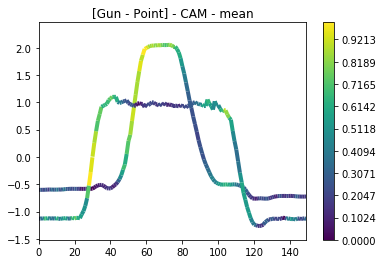

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.viridis)

### gist_gray_r

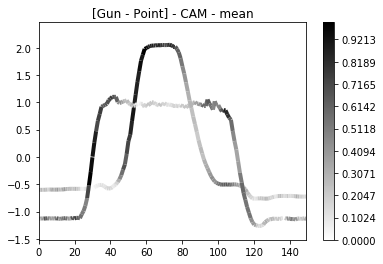

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.gist_gray_r)

## Using different line styles
> line styles : [ 'solid' | 'dashed' | 'dashdot' | 'dotted' ]

### Line Style : `solid` - By default

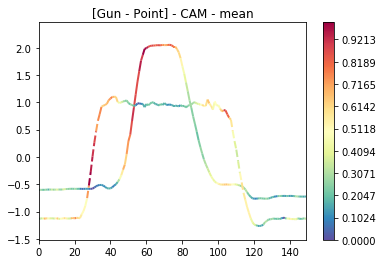

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, linewidth=2, linestyles='solid')

### Line Style : `dashed`

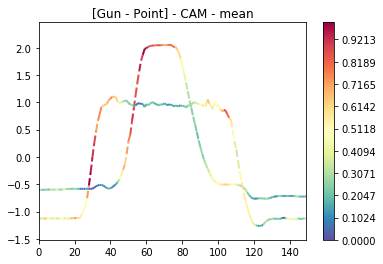

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, linewidth=2, linestyles='dashed')

### Line Style : `dashdot`

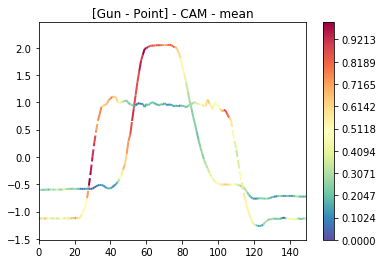

In [ ]:
# Gun - CAM - max
show_cam(batch, model, layer=5, i2o=i2o, linewidth=2, linestyles='dashdot')

### Line Style : `dotted`

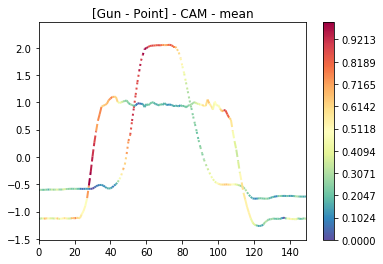

In [ ]:
# Gun - CAM - max
show_cam(batch, model, layer=5, i2o=i2o, linewidth=2, linestyles='dotted')

## How to use your customized CAM function
> The user can create their own CAM function. Check out how both `cam_acts` and `grad_acts_cam` are define here above. Here below, as an illustration, we create a partial function that used `cam_acts` function

In [ ]:
#Example using a partial
cam_acts_1 = partial(cam_acts, force_scale=False, scale_range=(0,2))
cam_acts_1.name = r'cam_acts_1'

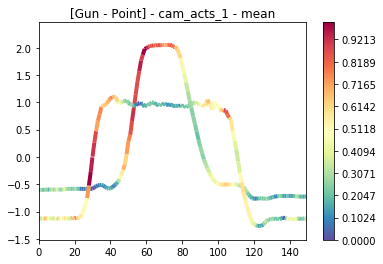

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=cam_acts_1)

In [ ]:
# Using different cmap
# **cmap possible values are: **

cmap_list = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']

cmaps = [f'{n} = \'{n}\'' for n in cmap_list]
# cmaps

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 80_timeseries_data.ipynb.
Converted 81_timeseries_core.ipynb.
Converted 82_univariate_timeseries_CAM.ipynb.
Converted Colab_timeseries_Tutorial.ipynb.
Converted cam_tutorial_ECG200.ipynb.
Converted cam_tutorial_GunPoint.ipynb.
Converted index.ipynb.
Converted training_using_default_settings.ipynb.
Converted univariate_timeseries_Tutorial.ipynb.


## Palettes

![](images/cmap/perceptual.png)
![](images/cmap/diverging.png)
![](images/cmap/sequential.png)
![](images/cmap/sequential_2.png)
![](images/cmap/cyclic.png)
![](images/cmap/qualitative.png)
![](images/cmap/misc.png)

![](images/montreal-pont-jacques-cartier.jpg)